# ニューラルネットワークの学習

## 学習とは
- 訓練データから最適な重みパラメータの値を自動で獲得すること
- 本章では、NNが学習を行えるようにするために、損失関数という「指標」を導入する。
  - この損失関数を基準として、その値が最も小さくなる重みパラメータを探し出すということが学習の目的。
- 本章では、できるだけ小さな損失関数の値を探し出すためにの手法として、**勾配法**と呼ばれる、関数の傾きを使った手法を用いる。

## データから学習する

- NNの特徴
  - データから学習できること（≒重みパラメータの値をデータから自動で決定できること）
  - 実際のNNでは、パラメータの数が数千、数万に及ぶ

## データ駆動

- 機械学習はデータが命
- 例）MNISTで、5かそれ以外かを認識するアルゴリズム
  - 画像から**特徴量**を抽出して、その特徴量のパターンを機械学習の技術で学習する方法
  - ここでいう特徴量とは
    - 入力データ（入力画像）から本質的なデータ（重要なデータ）を的確に抽出できるように設計された変換器を指す。
    - 画像の特徴量は、通常ベクトルとして記述される
        - コンピュータビジョン分野では、SIFTやSURF、HOGなどが挙げられる
  - そのような特徴量を用いて、画像データをベクトルに変換し、その変換されたベクトルに対して、機械学習で使われる識別器（SVMやKNNなど）で学習させる

## 訓練データとテストデータ

- なぜ訓練データ（教師データ）とテストデータを分けるのか？
    - モデルの汎用的な能力（汎化能力）を正しく評価するため。
- あるデータセットだけに過度に対応した状態を**過学習**という

## 損失関数

- NNで用いられる指標
- 値が小さい方が精度がいい
- NNの学習では、ある「一つの指標」によって現在の状態を表す。
    - そしてその指標を基準として、最適な重みパラメータの探索を行う。
- 例）2乗和誤差、交差エントロピー誤差

## 2乗和誤差
↓にMNISTの例を示す

In [42]:
# NNの出力
y_2 = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
y_7 = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]

# 訓練データ（教師データ） ※2が正解
t = [0,0,1,0,0,0,0,0,0,0]

In [43]:
import numpy as np

def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)

In [44]:
# 「2」の確率が最も高い場合（0.6）
mean_squared_error(np.array(y_2), np.array(t))

0.09750000000000003

In [45]:
# 「7」の確率が最も高い場合（0.6）
mean_squared_error(np.array(y_7), np.array(t))

0.5975

## 交差エントロピー誤差

In [46]:
def cross_entropy_error(y,t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta)) # np.log(0)はマイナス無限大となるので、微小な値をプラスしている

In [47]:
# 「2」の確率が最も高い場合（0.6）
cross_entropy_error(np.array(y_2), np.array(t))

0.510825457099338

In [48]:
# 「7」の確率が最も高い場合（0.6）
cross_entropy_error(np.array(y_7), np.array(t))

2.302584092994546

## ミニバッチ学習

- 損失関数は、訓練データが100個あれば、その100個の損失関数の和を指標とする
- 1個あたりの「平均の損失関数」を求める

## [バッチ対応版] 交差エントロピー誤差の実装
- yの次元が1の場合、つまり、データ一つあたりの交差エントロピー誤差を求める場合は、データの形状を整形する。
- バッチの枚数で正規化し、1枚あたりの平均の交差エントロピー誤差を計算する
- one-hot表現でtが0の要素は、交差エントロピー誤差も0であるから、その計算は無視しても良い
    - 正解ラベルに対してだけ、NNの出力を得られれば、交差エントロピー誤差の計算はできる。
    - 該当箇所：`-np.sum(np.log(y[np.arange(batch_size), t] + 1e-7))/batch_size`
    - `np.arange(batch_size)`は、0から`batch_size-1`までの配列を生成する。例えば、`batch_size`が5だとしたら、`np.arange(batch_size)`は`[0,1,2,3,4]`のNumPy配列を生成する。tにはラベルが`[2,7,0,9,4]`のように格納されているので、`y[np.arange(batch_size), t]`は、各データの正解ラベルに対応するNNの出力を抽出する（この例では、`[y[0,2],y[1,7],y[2,0],y[3,9],y[4,4]]`のNumpy配列

In [49]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size) # reshapeで配列の形を整える
        y = y.reshape(1, y.size)
    
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7))/batch_size

## なぜ損失関数を設定するのか？

- NNの学習における「微分」の役割
- NNの学習では、最適パラメータ（重みとバイアス）を探索する際に、損失関数の値ができるだけ小さくなるようなパラメータを探す。
    - ここで、できるだけ小さな損失関数の場所を探すために、パラメータの微分（正確には勾配）を計算し、その微分の値を手がかりにパラメータの値を徐々に更新していく
    - 例) NNのある一つの重みパラメータに注目すると、一つの重みパラメータの損失関数に対する微分は「その重みパラメータを正の方向へ変化させることで、損失関数がどのように変化するか」ということを表す。
        - もし、その微分の値がマイナスとなれば、その重みパラメータを正の方向へ変化させることで、損失関数を減少させることができる。逆に、その微分の値がプラスであれば、その重みパラメータを負の方向へ変化させることで、損失関数を減少させることができる。しかし、微分の値が0になると、重みパラメータをどちらに動かしても、損失関数の値が変わらないため、その重みパラメータの更新はそこでストップする。
- 認識精度を指標にしてはいけないのか？
    - 微分がほとんどの場所で0になってしまい、パラメータの更新ができなくなってしまうから

## 数値微分

In [73]:
def numerical_diff(f, x):
    h = 1e-4 # 0.0001
    return (f(x+h) - f(x-h)) / (2*h)

In [74]:
def function_1(x):
    return 0.01*x**2 + 0.1*x

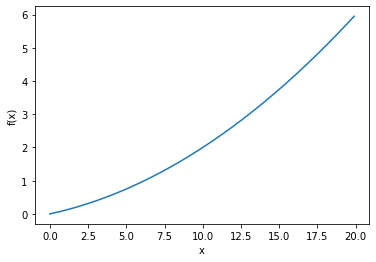

In [75]:
import numpy as np
import matplotlib.pylab as plt

x = np.arange(0.0, 20.0, 0.1) # 0~20まで、0.1刻みの配列
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(x, y)
plt.show()

In [76]:
# x=5で微分
numerical_diff(function_1, 5)

0.1999999999990898

In [77]:
# x=10で微分
numerical_diff(function_1, 10)

0.2999999999986347

## 偏微分

- 1変数の微分と同じで、ある場所の傾きを求める
- ただし、偏微分の場合、複数ある変数の中でターゲットとする変数以外を特定の値に固定するために、新しい関数を定義する必要あり

In [78]:
def function_2(x):
    return x[0]**2 + x[1]**2

In [79]:
# x0=3,x1=4の時のx0に対する偏微分
def function_tmp1(x0):
    return x0*x0 + 4.0**2.0

numerical_diff(function_tmp1, 3.0)

6.00000000000378

In [82]:
# x0=3,x1=4の時のx1に対する偏微分
def function_tmp2(x1):
    return 3.0**2 + x1*x1

numerical_diff(function_tmp2, 4.0)

7.999999999999119

## 勾配

- 勾配が示す方向は、**各場所において関数の値を最も減らす方向**

In [86]:
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x) # xと同じ形状の配列を生成　
    
    for idx in range(x.size):
            tmp_val = x[idx]
            # f(x+h)の計算
            x[idx] = tmp_val + h
            fxh1 = f(x)
            
            # f(x-h)の計算
            x[idx] = tmp_val - h
            fxh2 = f(x)
            
            grad[idx] = (fxh1 - fxh2)/(2*h)
            x[idx] = tmp_val # 値を元に戻す
        
    return grad

In [87]:
numerical_gradient(function_2, np.array([3.0, 4.0]))

array([6., 8.])

In [88]:
numerical_gradient(function_2, np.array([0.0, 2.0]))

array([0., 4.])

In [89]:
numerical_gradient(function_2, np.array([3.0, 0.0]))

array([6., 0.])

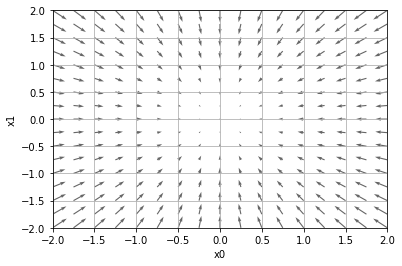

In [90]:
# coding: utf-8
# cf.http://d.hatena.ne.jp/white_wheels/20100327/p3
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D


def _numerical_gradient_no_batch(f, x):
    h = 1e-4  # 0.0001
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)  # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x)  # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val  # 値を元に戻す
        
    return grad


def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)
        
        return grad


def function_2(x):
    if x.ndim == 1:
        return np.sum(x**2)
    else:
        return np.sum(x**2, axis=1)


def tangent_line(f, x):
    d = numerical_gradient(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y


if __name__ == '__main__':
    x0 = np.arange(-2, 2.5, 0.25)
    x1 = np.arange(-2, 2.5, 0.25)
    X, Y = np.meshgrid(x0, x1)
    
    X = X.flatten()
    Y = Y.flatten()

    grad = numerical_gradient(function_2, np.array([X, Y]).T).T

    plt.figure()
    plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666")
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.grid()
    plt.draw()
    plt.show()

## 勾配法

- 現在の場所から勾配方向に一定の距離だけ進む
- 移動した先でも同様に勾配を求める
- その勾配方向へ進む
- 上記を繰り返し、関数の値を徐々に減らす

$$
x_0 = x_0 - η \frac{∂f}{∂x_0} \\
% 複数文字を1要素とする際は{...}で囲う
% 空白は"\quad"
x_1 = x_1 - η \frac{∂f}{∂x_1} \\
$$

- η：学習率（learning rate）
    - 1回の学習で、どれだけ学習すべきか、どれだけパラメータを更新するか、ということを決めるもの
    - 予め決める必要がある。
    - この値は、大きすぎても小さすぎても「良い場所」に辿り着くことができない。
    - NNの学習においては、学習率の値を変更しながら、正しく学習できているかどうか、確認作業を行う。
    - 学習率などのように、自身で設定するパラメータを**ハイパーパラメータ**という
- 上記の式は、1回の更新式を示し、これを繰り返して行う
    - つまり、ステップごとに変数の値を更新していき、そのステップを何度か繰り返すことによって徐々に関数の値を減らしていく

## 勾配降下法の実装

- 変数
    - f：最適化したい関数
    - init_x：初期値
    - lr：学習率
    - step_num：勾配法による繰り返しの数
- 処理概要
    - 関数の勾配は、`numerial_gradient(f, x)`で求めて、その勾配に学習率をかけた値で更新する処理を`step_num`で指定された回数繰り返す
    - この関数を使えば、関数の極小値を求めることができ、うまくいけば最小値を求めることができる

In [103]:
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    
    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= lr * grad
    
    return x

$$ f(x_0,x_1) = x_0^2 + x_1^2 $$　

上式の最小値を勾配法で求める

- ↓では、初期値を(-3.0, 4.0)として、勾配法を使って最小値の探索を開始する
- 最終的な結果は、(-6.1e-10, 8.1e-10)となり、これはほとんど(0,0)に近い結果となる
- 実際、真の最小値は(0,0)なので、勾配法によって、ほぼ正しい結果が得られた

In [96]:
def function_2(x):
    return x[0]**2 + x[1]**2

init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x=init_x, lr=0.1, step_num=100)

array([-6.11110793e-10,  8.14814391e-10])

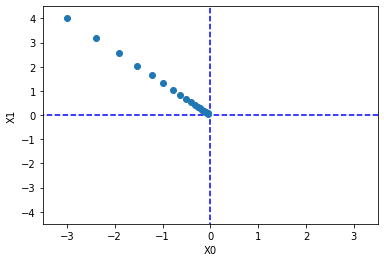

In [101]:
# 図の描画用コード
import numpy as np
import matplotlib.pylab as plt

def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    x_history = []

    for i in range(step_num):
        x_history.append( x.copy() )

        grad = numerical_gradient(f, x)
        x -= lr * grad

    return x, np.array(x_history)

def function_2(x):
    return x[0]**2 + x[1]**2

init_x = np.array([-3.0, 4.0])    

lr = 0.1
step_num = 20
x, x_history = gradient_descent(function_2, init_x, lr=lr, step_num=step_num)

plt.plot( [-5, 5], [0,0], '--b')
plt.plot( [0,0], [-5, 5], '--b')
plt.plot(x_history[:,0], x_history[:,1], 'o')

plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("X0")
plt.ylabel("X1")
plt.show()

In [104]:
# 学習率が大きすぎる例
init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x=init_x, lr=10.0, step_num=100)

array([-2.58983747e+13, -1.29524862e+12])

In [105]:
# 学習率が小さすぎる例
init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x=init_x, lr=1e-10, step_num=100)

array([-2.99999994,  3.99999992])

$$
\boldsymbol{W} =
% ベクトルや行列は"left["と"right]"でベクトルや行列の括弧を作る
% 括弧内に"array"環境を展開する
% {c|cc}の形で中央揃え、縦線、中央揃え*2の並びに出来る
\left[\begin{array}{c}
    w_{11} &  w_{12} &  w_{13}\\
    w_{21} &  w_{22} &  w_{23}
\end{array}\right] \quad
\\
\frac{∂L}{∂\boldsymbol{W}} =
\left[\begin{array}{c}
    \frac{∂L}{∂w_{11}} &  \frac{∂L}{∂w_{12}} &  \frac{∂L}{∂w_{13}}\\
    \frac{∂L}{∂w_{21}} &  \frac{∂L}{∂w_{22}} &  \frac{∂L}{∂w_{23}}
\end{array}\right] \quad
$$

- ∂L/∂W の各要素は、それぞれの要素に関する偏微分から構成される。
- 例えば、∂L/∂w11 は、w11を少し変化させると損失関数Lがどれだけ変化するかということを表す

## simpleNetの実装
- 形状が2×3の重みパラメータを一つだけインスタンス変数としてもつ
- 2つのメソッド
    - 予測するためのメソッド predict(x)
    - 損失関数の値を求めるためのメソッド loss(x, t)
- 引数
    - x：入力データ
    - t：正解ラベル

In [109]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from common.functions import softmax, cross_entropy_error
from common.gradient import numerical_gradient

class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3) # ガウス分布で初期化
        
    def predict(self, x):
        return np.dot(x, self.W)
    
    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y,t)
    
        return loss

## 

In [110]:
net = simpleNet()
print(net.W)

[[-0.05678343  0.72435901  1.49378906]
 [ 0.0315609  -0.45746927  0.85627972]]


In [112]:
x = np.array([0.6, 0.9])
p = net.predict(x)
print(p)

[-0.00566525  0.02289306  1.66692518]


In [114]:
np.argmax(p) # 最大値のインデックス

2

In [116]:
t = np.array([0,0,1]) # 正解ラベル
net.loss(x,t)

0.32277842502630116

続いて、勾配を求めてみる
- 下記の結果について
    - w11をhだけ増やすと、損失関数f(W)は、0.08157807hだけ増加するということ

NNの勾配を求めれば、あとは勾配法に従って、重みパラメータを更新するだけ。（次節）

In [117]:
def f(W):
    return net.loss(x,t)

dW = numerical_gradient(f, net.W)
print(dW)

[[ 0.08157807  0.08394139 -0.16551947]
 [ 0.12236711  0.12591209 -0.2482792 ]]


## 学習アルゴリズムの実装

- NNの学習に関する基本的な知識は全て出揃った
    - 損失関数
    - ミニバッチ
    - 勾配
    - 勾配降下法　　etc..
- NNの学習手順
    - 前提
        - NNは、適応可能な重みとバイアスがあり、この重みとバイアスを訓練データに適応するように調整することを**「学習」**と呼ぶ
    - 手順
        - 1) ミニバッチ
            - 訓練データの中からランダムに一部のデータ（ミニバッチ）を選ぶ
            - ここでは、ミニバッチの損失関数の値を減らすことを目的とする
        - 2) 勾配の算出
            - ミニバッチの損失関数を減らすために、各重みパラメータの勾配を求める
            - 勾配は損失関数の値を最も減らす方向を示す
        - 3) パラメータの更新
            - 重みパラメータを勾配法こうに微少量だけ更新する
        - 4) 繰り返し
            - 1)~3)を繰り返す
    - 名称
        - この方法を、**SGD**もしくは**確率的勾配降下法**という。
        - 確率的に無作為に選び出したデータに対して行う勾配降下法

## 2層ニューラルネットワークのクラス

### 変数
- params	
    - ニューラルネットワークのパラメータを保持するディクショナリ変数（インスタンス変数）
        - `params['Wn']`はn層目の重み
        - `params['bn']`はn層目のバイアス
- grad	
    - 勾配を保持するディクショナリ変数（numerical_gradient()メソッドの返り値
        - `params['Wn']`はn層目の重みの勾配
        - `params['bn']`はn層目のバイアスの勾配

### メソッド
- `__init__(self, input_size, hidden_size, ouput_size)`
    - 初期化を行う
    - 筆記数は頭から順に、入力層のニューロンの数、隠れ層のニューロンの数、出力層のニューロンの数
- `predict(self,x)`
    - 認識（推論）を行う
    - 引数のxは画像データ
- `loss(self, x, t)`
    - 損失関数の値を求める
    - 引数のxは画像データ
- `loss(self,x,t)`
    - 損失関数の値を求める
    - 引数のxは画像データ、tは正解ラベル（以下の3つのメソッドの引数についても同様）
- `accuracy(self, x, t)`
    - 認識制度を求める
- `numerical_gradient(self, x, t)`
    - 重みパラメータに対する勾配を求める
- `gradient(self, x, t)`
    - 重みパラメータに対する勾配を求める
    - `numerical_gradient()`の高速版！

In [118]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
from common.functions import *
from common.gradient import numerical_gradient
import numpy as np


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:入力データ, t:教師データ
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        dz1 = np.dot(dy, W2.T)
        da1 = sigmoid_grad(a1) * dz1
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1, axis=0)

        return grads

## ミニバッチ学習の実装
train_neural_network.py参照

In [ ]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000  # 繰り返しの回数を適宜設定する
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配の計算
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1エポックごとに認識精度を計算
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()